In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, diags

In [4]:
csv = "netflix-prize-data/processed_data.csv"
names = ["user_id", "film_rating", "film_id"]

data = pd.read_csv(csv, header=None, names=names, nrows=2000000)
one_hot_encoder = OneHotEncoder(categories="auto")

user_ids = one_hot_encoder.fit_transform(np.asarray(data['user_id']).reshape(-1,1))
film_ids = one_hot_encoder.fit_transform(np.asarray(data['film_id']).reshape(-1,1))

X = hstack([np.ones(shape=(2000000, 1)), user_ids, film_ids]).tocsr()
y = np.asarray(data['film_rating']).reshape(-1,1)

X,y = shuffle(X,y)

In [6]:
def mean_square_error(Y, previous_Y):
    return np.sum(np.square(Y - previous_Y)) / len(Y)

def sqrt_mean_square_error(Y, previous_Y):
    return np.sqrt(mean_square_error(Y, previous_Y))

# Also known as R^2
def coefficient_of_determination(Y, previous_Y):
    return 1 - (np.sum(np.square(Y - previous_Y))) / (np.sum(np.square(Y - Y.mean())))

In [7]:
def predict(X, w, V):
    first = np.sum(np.square(X.dot(V)), axis=1)
    second = np.sum(X.power(2).dot(np.square(V)), axis=1)
    return X.dot(w) + 0.5 * (first - second).reshape(-1,1)

In [8]:
def step(X, y, w, V):
    w += (0.1 / len(y)) * X.T.dot(y - X.dot(w))
    XV = X.dot(V)
    y_pred = predict(X, w, V)
    for index in range(V.shape[1]):
        first_diagonal = diags(np.array(XV)[:, index])
        first = first_diagonal.dot(X)
        second_diagonal = diags(V[:, index])
        second = X.power(2).dot(second_diagonal)
        V[:, index] += (0.1 / X.shape[1]) * (first - second).T.dot(y - y_pred).reshape((-1,))
    return w, V

In [9]:
number_of_splits = 5
number_of_epochs = 100
factors_num = 2

In [10]:
def gradient_descent(X, y, w_iniitial, V_initial):
    w = w_iniitial
    V = V_initial
    mean_square_error_values = list()
    for epoch in range(number_of_epochs):
        w_next, V_next = step(X, y, w, V)
        y_pred = predict(X, w_next, V_next)
        mean_square_error_values.append(mean_square_error(y, y_pred))
        if epoch % 10 == 0:
            print(f"\tEpoch: {epoch}, MSE: {mean_square_error_values[epoch]}")
        w = w_next
        V = V_next
    return w, V, mean_square_error_values

In [11]:
mean_square_error_values     = [0 for _ in range(number_of_splits)]
weights    = [0 for _ in range(number_of_splits)]
factors    = [0 for _ in range(number_of_splits)]
rmse_train = [0 for _ in range(number_of_splits)]
rmse_test  = [0 for _ in range(number_of_splits)]
r2s_train  = [0 for _ in range(number_of_splits)]
r2s_test   = [0 for _ in range(number_of_splits)]

kf = KFold(n_splits=number_of_splits, shuffle=True)
kf.get_n_splits(X)

for index, (train_subset, test_subset) in enumerate(kf.split(X)):
    print(f"Running split option {index}")
    X_train, X_test = X[train_subset], X[test_subset]
    y_train, y_test = y[train_subset], y[test_subset]
    w_iniitial = np.zeros((X.shape[1], 1))
    V_initial = np.zeros((X.shape[1], factors_num))
    results = gradient_descent(X_train, y_train, w_iniitial, V_initial)
    weights[index], factors[index], mean_square_error_values[index] = results
    train_preds = predict(X_train, weights[index], factors[index])
    test_preds = predict(X_test, weights[index], factors[index])
    rmse_train[index] = sqrt_mean_square_error(y_train, train_preds)
    rmse_test[index] = sqrt_mean_square_error(y_test, test_preds)
    r2s_train[index] = coefficient_of_determination(y_train, train_preds)
    r2s_test[index] = coefficient_of_determination(y_test, test_preds)

Running split option 0
	Epoch: 0, MSE: 11.734313699819602
	Epoch: 10, MSE: 2.3619593620436503
	Epoch: 20, MSE: 1.2801839683178302
	Epoch: 30, MSE: 1.153748522176937
	Epoch: 40, MSE: 1.1374705494637778
	Epoch: 50, MSE: 1.1339617304143517
	Epoch: 60, MSE: 1.1319960591278535
	Epoch: 70, MSE: 1.13027563110919
	Epoch: 80, MSE: 1.128646798006961
	Epoch: 90, MSE: 1.127088053990099
Running split option 1
	Epoch: 0, MSE: 11.73546220874112
	Epoch: 10, MSE: 2.3614663248477337
	Epoch: 20, MSE: 1.279525922255409
	Epoch: 30, MSE: 1.1530661648786928
	Epoch: 40, MSE: 1.1367773232563732
	Epoch: 50, MSE: 1.1332594362845319
	Epoch: 60, MSE: 1.1312854582239456
	Epoch: 70, MSE: 1.1295573567081487
	Epoch: 80, MSE: 1.1279214284217849
	Epoch: 90, MSE: 1.1263561204740453
Running split option 2
	Epoch: 0, MSE: 11.735155584215853
	Epoch: 10, MSE: 2.362076523535126
	Epoch: 20, MSE: 1.2802477828580066
	Epoch: 30, MSE: 1.153808999435701
	Epoch: 40, MSE: 1.1375303891437187
	Epoch: 50, MSE: 1.1340209656290465
	Epoch:

Populating the interactive namespace from numpy and matplotlib


/home/kirill/anaconda3/envs/scientificProject/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'hstack', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


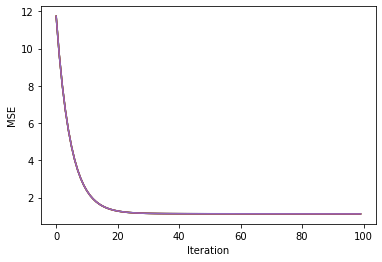

In [12]:
%pylab inline
for error_by_iter in mean_square_error_values:
    plot(range(len(error_by_iter)), error_by_iter)
    xlabel('Iteration')
    ylabel('MSE')

In [13]:
columns = ["Names"]
columns += [f"T{i + 1}" for i in range(number_of_splits)]
columns.append("Mean")
columns.append("Std")

rows =  ["RMSE train", "RMSE test", "R2 train", "R2 test"]
rows += [f"Feature {i + 1}" for i in range(len(weights[0]))]

In [15]:
result = pd.DataFrame(columns=columns)
result["Names"] = rows
result.set_index("Names", inplace=True)

for i in range(number_of_splits):
    data = np.concatenate(([rmse_train[i], rmse_test[i], r2s_train[i], r2s_test[i]], weights[i].reshape((-1,))))
    result[f"T{i + 1}"] = data

result["Mean"] = result.mean(axis=1)
result["Std"] = result.std(axis=1)

In [16]:
result

,T1,T2,T3,T4,T5,Mean,Std
Names,,,,,,,
RMSE train,1.061009,1.060661,1.061036,1.060808,1.061545,1.061012,0.000300
RMSE test,1.061072,1.062367,1.060954,1.061834,1.058889,1.061023,0.001185
R2 train,0.025487,0.025570,0.025536,0.025578,0.025531,0.025540,0.000032
R2 test,0.025664,0.025503,0.025488,0.025379,0.025551,0.025517,0.000093
Feature 1,3.531299,3.531551,3.531324,3.531233,3.530868,3.531255,0.000221
...,...,...,...,...,...,...,...
Feature 342803,0.087042,0.087367,0.087157,0.085839,0.087376,0.086956,0.000573
Feature 342804,0.005003,0.005260,0.005059,0.005207,0.005373,0.005180,0.000134
Feature 342805,0.021801,0.022372,0.021702,0.021408,0.021558,0.021768,0.000330
